In [105]:
import numpy as np
import matplotlib.pyplot as plt
from zhinst.toolkit import Session
from time import sleep

# ========== USER SETTINGS ==========
DEVICE_ID = "DEV30370"         # Replace with your MFLI device ID
SERVER_HOST = "localhost"     # or IP of data server
SERVER_PORT = 8004             # default for MFLI
INTERFACE = "USB"              # or "ETH"

TARGET_FREQ = 163.97e3         # 163.97 kHz
AMPLITUDE_PEAK = 0.074         # 73 mV peak
SAMPLE_RATE = 60e6              # 10 MSa/s (enough for 300kHz+)
SCOPE_TIME = 0.001              # 10 ms capture

SCOPE_CHANNEL = 0
SIGNAL_INPUT = 0
SIGNAL_OUTPUT = 0

# ========== CONNECT ==========
device_id = 'DEV30370'
server_host = 'localhost'
server_port = 8004  # your DAQ server port

# Connect to device
session = Session("localhost")
device = session.connect_device("DEV30370", interface="1GbE")

In [106]:
# Enable output
device.sigouts[0].on(True)

device.sigouts[0].amplitudes(AMPLITUDE_PEAK)

# Set oscillator frequency
device.oscs[0].freq(TARGET_FREQ)

# Route oscillator 0 to output 0
device.sigouts[0].source = 0

print("Output configured:")
print(f"Frequency: {TARGET_FREQ/1e3:.2f} kHz")
print(f"Amplitude: {AMPLITUDE_PEAK*1000:.2f} mV peak")

Output configured:
Frequency: 163.97 kHz
Amplitude: 74.00 mV peak


In [107]:
if device.sigins[SIGNAL_INPUT].autorange(1, deep=True) != 0:
    # The auto ranging takes some time. We do not want to continue before the
    # best range is found. Therefore, we wait for state to change to 0.
    # These nodes maintain value 1 until autoranging has finished.
    device.sigins[SIGNAL_INPUT].autorange.wait_for_state_change(0, timeout=20)

with device.set_transaction():
    device.scopes[0].length(SAMPLE_RATE * SCOPE_TIME)
    device.scopes[0].channel(1)
    device.scopes[0].channels[0].bwlimit(1)
    device.scopes[0].channels[0].inputselect(SIGNAL_INPUT)
    device.scopes[0].time(SCOPE_TIME)
    device.scopes[0].single(False)
    device.scopes[0].trigenable(False)
    device.scopes[0].trigholdoff(0.050)
    device.scopes[0].segments.enable(False)

In [109]:
MIN_NUMBER_OF_RECORDS = 1

scope_module = session.modules.scope
scope_module.mode(1)
scope_module.averager.weight(1)
scope_module.historylength(1)
scope_module.fft.window(0)

wave_node = device.scopes[0].wave
scope_module.subscribe(wave_node)

In [6]:
import time

def check_scope_record_flags(scope_records, num_records):
    """
    Loop over all records and print a warning to the console if an error bit in
    flags has been set.
    """
    num_records = len(scope_records)
    for index, record in enumerate(scope_records):
        record_idx = f"{index}/{num_records}"
        record_flags = record[0]["flags"]
        if record_flags & 1:
            print(f"Warning: Scope record {record_idx} flag indicates dataloss.")
        if record_flags & 2:
            print(f"Warning: Scope record {record_idx} indicates missed trigger.")
        if record_flags & 4:
            print(f"Warning: Scope record {record_idx} indicates transfer failure" \
                "(corrupt data).")

        totalsamples = record[0]["totalsamples"]
        for wave in record[0]["wave"]:
            # Check that the wave in each scope channel contains
            # the expected number of samples.
            assert (
                len(wave) == totalsamples
            ), f"Scope record {index}/{num_records} size does not match totalsamples."


def get_scope_records(scope_module, num_records: int):
    """Obtain scope records from the device using an instance of the Scope Module."""
    scope_module.execute()
    device.scopes[0].enable(True)
    session.sync()

    start = time.time()
    timeout = 30 # [s]
    records = 0
    progress = 0
    # Wait until the Scope Module has received and processed
    # the desired number of records.
    while (records < num_records) or (progress < 1.0):
        time.sleep(0.5)
        records = scope_module.records()
        progress = scope_module.progress()
        print(
            f"Scope module has acquired {records} records (requested {num_records}). "
            f"Progress of current segment {100.0 * progress}%.",
            end="\r",
        )
        if (time.time() - start) > timeout:
            # Break out of the loop if for some reason we're no longer receiving
            # scope data from thedevice
            print(
                f"\nScope Module did not return {num_records} records after {timeout} s - \
                    forcing stop."
            )
            break

    device.scopes[0].enable(False)
    # Read out the scope data from the module.
    data = scope_module.read()[wave_node]
    # Stop the module; to use it again we need to call execute().
    scope_module.finish()
    check_scope_record_flags(data, num_records)
    return data

In [110]:
data_no_trig = get_scope_records(scope_module, MIN_NUMBER_OF_RECORDS)

scope_module.mode(3)
scope_module.fft.window(1) # Hann window function
data_fft = get_scope_records(scope_module, MIN_NUMBER_OF_RECORDS)

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib widget

clockbase = device.clockbase()

def plot_time_domain(axis, scope_records, scope_input_channel, record_index=None):
    """
    Plots scope data on the given axis.
    
    Parameters:
        axis: matplotlib axis
        scope_records: list of scope records
        scope_input_channel: which channel to plot
        record_index: int or None; if specified, plot only this record
    """
    # Decide which records to plot
    if record_index is None:
        records_to_plot = scope_records
        colors = cm.rainbow(np.linspace(0, 1, len(scope_records)))
    else:
        records_to_plot = [scope_records[record_index]]
        colors = [cm.rainbow(0)]  # single color

    def to_timestamp(record):
        totalsamples = record[0]["totalsamples"]
        dt = record[0]["dt"]
        timestamp = record[0]["timestamp"]
        triggertimestamp = record[0]["triggertimestamp"]
        t = np.arange(-totalsamples, 0) * dt + (
            timestamp - triggertimestamp
        ) / float(clockbase)
        return 1e6 * t

    for idx, record in enumerate(records_to_plot):
        wave = record[0]["wave"][scope_input_channel, :]
        ts = to_timestamp(record)
        axis.plot(ts, wave, color=colors[idx])

    axis.grid(True)
    axis.set_ylabel("Amplitude [V]")
    axis.autoscale(enable=True, axis="x", tight=True)
    plt.draw()


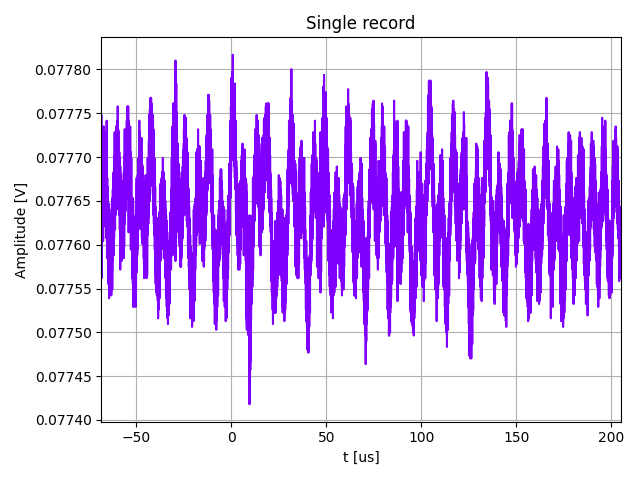

In [111]:
fig, ax = plt.subplots()
plot_time_domain(ax, data_no_trig, SCOPE_CHANNEL, record_index=2)
ax.set_title("Single record")
ax.set_xlabel("t [us]")
plt.tight_layout()
plt.show()


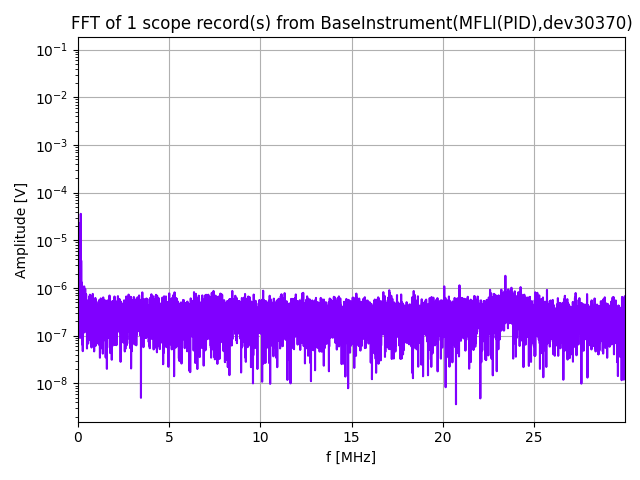

In [112]:


def to_frequency(record, scope_time):
    totalsamples = record[0]["totalsamples"]
    scope_rate = clockbase / 2 ** scope_time
    return np.linspace(0, scope_rate / 2, totalsamples) / 1e6

# Choose which record(s) to plot
record_index = 0  # set to an integer to plot only that record, e.g., 0
records_to_plot = data_fft if record_index is None else [data_fft[record_index]]

# Plot the FFT of the scope data.
_, axis = plt.subplots()
axis.set_xlabel("f [MHz]")
axis.set_ylabel("Amplitude [V]")
axis.grid(True)

colors = cm.rainbow(np.linspace(0, 1, len(records_to_plot)))
for idx, record in enumerate(records_to_plot):
    wave = record[0]["wave"][SCOPE_CHANNEL, :]
    freq = to_frequency(record, SCOPE_TIME)
    axis.semilogy(freq, wave, color=colors[idx])

title_text = f"FFT of {len(records_to_plot)} scope record(s) from {device}"
axis.set_title(title_text)
axis.autoscale(enable=True, axis="x", tight=True)
plt.tight_layout()
plt.draw()
plt.show()



In [ ]:
import pickle

with open("scope_data_1013mbar_74mV_80deg.pkl", "wb") as f:
    pickle.dump(data_no_trig, f)

with open("fft_data_1013mbar_74mV_80deg.pkl", "wb") as f:
    pickle.dump(data_fft, f)

In [ ]:
data_no_trig

[[{'header': {'systemtime': array([1764855341], dtype=uint64),
    'createdtimestamp': array([23177730399], dtype=uint64),
    'changedtimestamp': array([23177730399], dtype=uint64),
    'flags': array([57], dtype=uint32),
    'moduleflags': array([0], dtype=uint32),
    'chunksizebytes': array([65784], dtype=uint64),
    'name': '009 14:35:41.0377',
    'status': array([0], dtype=uint32),
    'groupindex': array([0], dtype=uint32),
    'color': array([0], dtype=uint32),
    'activerow': array([0], dtype=uint32),
    'triggernumber': array([0], dtype=uint64),
    'gridrows': array([1], dtype=uint32),
    'gridcols': array([16384], dtype=uint32),
    'gridmode': array([0], dtype=uint32),
    'gridoperation': array([0], dtype=uint32),
    'griddirection': array([0], dtype=uint32),
    'gridrepetitions': array([0], dtype=uint32),
    'gridcoldelta': array([0.]),
    'gridcoloffset': array([0.]),
    'gridrowdelta': array([0.]),
    'gridrowoffset': array([0.]),
    'bandwidth': array([0.]